In [172]:
'''Predicting Mortality across Germany wih different AI Methods
'''

import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
import dbf
from pygam import GAM, s, f, LinearGAM
import xgboost
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from pprint import pprint
from stabilityselection import Colinearity_Remover

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data

In [173]:
# Set the working directory
os.chdir("N:/WG_ENRI/20_projects/Noise2NAKO/04_data/grid_prediction/3_output")
grid_path = "N:/PROJECTS/ENVGEO_DB/1_GIS_data_orig/2_administrative_units/BKG/INSPIRE_geogitter/DE_Grid_ETRS89-LAEA/data/DE_Grid_ETRS89-LAEA_5km.gpkg"

In [174]:
# Read training and test data
data_training_path = 'Prediction/Reduced_data_SSel/Reduced_data_SSel_minmax_scaled_Training_data.csv'
data_test_path = 'Prediction/Reduced_data_SSel/Reduced_data_SSel_minmax_scaled_Test_data.csv'
data_training = pd.read_csv(data_training_path, sep=',')
data_test = pd.read_csv(data_test_path, sep=',')

In [175]:
# distinguish between response and input variables and make training and test data 
# remove unnecessary features 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'

output_variable = 'cvd_mortality_17'
# 0_original_data
# 1_standard_scaled_data
# 2_minmax_scaled_data
output_path = 'CVD Mortality Rate 2017_allExposures_XY/Reduced_data_SSel/2_minmax_scaled_data'

# output_variable = 'ks_Mortality_17'
# output_path = 'Total Mortality Rate 2017 incl XY'

output_path = '../5_results/' + output_path + '/'
coord = True

y = data_training[output_variable]
if coord:
    X = data_training.drop([output_variable, 'id'], axis = 1)   
else:
    X = data_training.drop([output_variable, 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'], axis = 1)
    
pred_y = data_test[output_variable]
if coord:
    pred_X = data_test.drop([output_variable, 'id'], axis = 1)
else:
    pred_X = data_test.drop([output_variable, 'id', 'x_sw', 'y_sw','x_mp', 'y_mp'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

# Prediction

In [176]:
def Create_grid_serach(method):
    
    # Create a parameter grid

    if (method == 'RF'):
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        pprint(random_grid)
        
    elif (method == 'AdaB'):
        # Number of trees in AdaBoost
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
        # The loss function to use when updating the weights after each boosting iteration
        loss = ['linear', 'square', 'exponential']
        # Weight applied to each regressor at each boosting iteration
        learning_rate = [float(x) for x in np.linspace(0.1, 2, num = 20)]
        # Create the random grid
        random_grid = {'learning_rate': learning_rate,
                       'loss': loss,
                       'n_estimators': n_estimators}
        pprint(random_grid)
        
    elif (method == 'XGBoost'):
        # Number of gradient boosted trees
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
        # Boosting learning rate
        learning_rate = [float(x) for x in np.linspace(0.01, 0.2, num = 20)]
        # Create the random grid
        random_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': learning_rate,
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': n_estimators}
        pprint(random_grid)
        
    elif (method == 'SVM'):
        # C parameter
        C = [0.1, 1, 10, 100]
        # kernel
        kernel = ['linear', 'poly', 'rbf', 'sigmoid']
        # Create the random grid
        random_grid = { 
            'C': C,
           'kernel': kernel
                      }
        pprint(random_grid)
        
    elif (method == 'KNN'):
        # Algorithm used to compute the nearest neighbors
        algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
        n_beighbors = list(range(1,30))
#         Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1),
#         and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.
        p = [1, 2]
#         Weight function used in prediction
        weight = ['uniform', 'distance']
#         Leaf size passed to BallTree or KDTree. 
        leaf_size = list(range(1,50))
        random_grid = {
            'algorithm': algorithm,
            'leaf_size': leaf_size,
                       'n_neighbors': n_beighbors,
                       'p': p,
                       'weights': weight
                      }
                
    return random_grid

In [177]:
def RandomSearch_Param_Tuning(model, method, itr, X, y, n_cv = 3, verbose = 2, rand_state = 42, jobs = -1):
    
    print('Runnig Random Search for parameter Tuning when Scoring is R-squared ..... ')
    
    grid = Create_grid_serach(method)
    random_model = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = itr, cv = n_cv,
                                      scoring= 'r2', verbose=2, random_state=42, n_jobs = -1)
    
    # Fit the random search model
    random_model.fit(X, y)
    
    return random_model.best_estimator_, random_model.best_params_, random_model

In [178]:
def GridSearch_Param_Tuning(model, method, X, y, grid = None, n_cv = 3, verbose = 2, jobs = -1):
    
    print('Runnig Grid Search for parameter Tuning  when Scoring is R-squared ..... ')
    
    if not grid:
        grid = Create_grid_serach(method)
    
    grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = n_cv, scoring= 'r2', n_jobs = jobs,
                               verbose = verbose)
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search

In [179]:
def Build_fit_model(method, X_train, y_train):
    
    if method == 'LR':
        model = linear_model.LinearRegression().fit(X_train, y_train)
    elif method == 'LR_Ridge':
        model = linear_model.RidgeCV(cv = 5).fit(X_train, y_train)
    elif method == 'LR_Lasso':
        model = linear_model.LassoCV(cv = 5, random_state=0).fit(X_train, y_train)
    elif method == 'LR_Elastic':
        model = linear_model.ElasticNetCV(cv = 5, random_state=0).fit(X_train, y_train)
    elif method == 'GAM':
        model = GAM().fit(X_train, y_train)
    elif method == 'RF':
        model = RandomForestRegressor()
        model, parameters, all_models = RandomSearch_Param_Tuning(model, method, 100, X_train, y_train)
    elif method == 'AdaB':
        model = AdaBoostRegressor()
        model, parameters, all_models = RandomSearch_Param_Tuning(model, method, 100, X_train, y_train)
    elif method == 'XGB':
        model = xgboost.XGBRegressor()
        model, parameters, all_models = RandomSearch_Param_Tuning(model, method, 100, X_train, y_train)
    elif method == 'SVM':
        model = SVR()
#         model, parameters, all_models = RandomSearch_Param_Tuning(model, method, 100, X_train, y_train)
        model, parameters, all_models = GridSearch_Param_Tuning(model, method, X_train, y_train)
        pprint(model.get_params())
    elif method == 'KNN':
        model = KNeighborsRegressor()
        model, parameters, all_models = RandomSearch_Param_Tuning(model, method, 100, X_train, y_train)
        pprint(model.get_params())
        
    return model

In [180]:
def Prediction(method, X_train, X_test, y_train, y_test, pred_X, pred_y, output_variable, output_path, data_training,
               data_test, grid_5km_shp):
    
    '''Prediction Function'''
    
    print(method + ' is running ... ')
    
    # First build and train the desired model
    model = Build_fit_model(method, X_train, y_train)
    
    # Validation and Evaluation of the model
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred = model.predict(pred_X)
    y_pred = pd.DataFrame(y_pred, columns = [output_variable])

    result = {'Method': method, 'MSE_train': mean_squared_error(y_train, y_pred_train),
                            'MAE_train': mean_absolute_error(y_train, y_pred_train), 'R_2_train': r2_score(y_train, y_pred_train),
                           'MSE_val': mean_squared_error(y_test, y_pred_test), 'MAE_val': mean_absolute_error(y_test, y_pred_test),
                           'R_2_val': r2_score(y_test, y_pred_test), 'MSE_pred': mean_squared_error(pred_y, y_pred), 'MAE_pred': mean_absolute_error(pred_y, y_pred),
                           'R_2_pred': r2_score(pred_y, y_pred)}
    
#     Merge dataframes to make the final output dataset 
    data_result= pd.DataFrame()
    data_result = data_result.append(data_training)
    data_result = data_result.append(pd.concat([data_test.drop([output_variable], axis = 1),pd.DataFrame(y_pred)],axis=1))
    data_result = data_result[['id', output_variable]]
    data_result.to_csv((output_path + method + '/prediction_result_' + method + '.csv'), sep=',', index=False)
    
#     Merge dataframes to make the Ground Truth
    GT = pd.DataFrame()
    GT = GT.append(data_training)
    GT = GT.append(pd.concat([data_test.drop([output_variable], axis = 1),pd.DataFrame(pred_y)],axis=1))
    GT = GT[['id', output_variable]]
    GT.to_csv((output_path + 'GT/GT.csv'), sep=',', index=False)   
    
#     Make the difference output
    data_diff_result= pd.DataFrame()
    data_diff_result = data_diff_result.append(data_training)
    data_diff_result[output_variable] = 0
    pred_variable = 'pred'+output_variable
    data_test = pd.concat([data_test, y_pred.rename(columns={output_variable: pred_variable})], axis=1)
    data_test[output_variable] = data_test[output_variable] - data_test[pred_variable]
    data_diff_result = data_diff_result.append(data_test.drop([pred_variable], axis = 1))
    data_diff_result = data_diff_result[['id', output_variable]]
    data_diff_result.to_csv((output_path + 'diff_' + method + '/prediction_result_diff_' + method + '.csv'), sep=',', index=False)
    
#     Make shp files
    merged_data = grid_5km_shp.merge(data_result, left_on="id", right_on="id")
#     merged_data_GT = grid_5km_shp.merge(GT, left_on="id", right_on="id")
    merged_data_diff = grid_5km_shp.merge(data_diff_result, left_on="id", right_on="id")
#     save the GeoDataFrame
    merged_data.to_file(driver = 'ESRI Shapefile', filename= output_path + method + '/' + method + '_shape.shp')
#     merged_data.to_file(driver = 'ESRI Shapefile', filename= output_path + 'GT/GT_shape.shp')
    merged_data_diff.to_file(driver = 'ESRI Shapefile', filename= output_path + 'diff_'+ method + '/diff_' + method + '_shape.shp')
    
    return result, y_pred, model

### Prediction with different methods

In [181]:
result = pd.DataFrame(columns=['Method', 'MSE_train', 'MAE_train', 'R_2_train', 'MSE_val', 'MAE_val', 'R_2_val', 'MSE_pred', 'MAE_pred', 'R_2_pred'])
# methods = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'SVM', 'RF', 'AdaB', 'XGBoost']
methods = ['KNN', 'SVM']
preds = pd.DataFrame()
preds['GT'] = pred_y

grid_5km_shp = gpd.read_file(grid_path)

for i in methods:
    ToAppend, y_pred, model = Prediction(i, X_train, X_test, y_train, y_test, pred_X, pred_y, output_variable,
                                 output_path, data_training, data_test, grid_5km_shp)
    print(i + ' is done!\n')
    result = result.append(ToAppend, ignore_index=True)
    preds[i] = y_pred
    
result.to_csv(output_path + 'PredictionTask_results_KNN_SVM.csv', index=False, sep=',')
result.round(decimals=3).to_csv(output_path + 'PredictionTask_results_KNN_SVM_round.csv', index=False, sep=',')

result

KNN is running ... 
Runnig Random Search for parameter Tuning when Scoring is R-squared ..... 
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algorithm': 'auto',
 'leaf_size': 38,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 1,
 'weights': 'distance'}
KNN is done!

SVM is running ... 
Runnig Grid Search for parameter Tuning  when Scoring is R-squared ..... 
{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
Fitting 3 folds for each of 16 candidates, totalling 48 fits
{'C': 1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}
SVM is done!



,Method,MSE_train,MAE_train,R_2_train,MSE_val,MAE_val,R_2_val,MSE_pred,MAE_pred,R_2_pred
0,KNN,0.000000,0.000000,1.000000,0.000968,0.014674,0.970227,0.01663,0.095833,0.484328
1,SVM,0.002838,0.042606,0.915004,0.002635,0.040533,0.918965,0.01182,0.085176,0.633462


### Make maps

In [182]:
# def single_map_plot(output_path, method, show_map = False):
    
#     data_shp = gpd.read_file(output_path + method + '/' + method + '_shape.shp')
#     fig, ax = plt.subplots(1, 1, figsize=(10,15))
#     data_shp.plot(column='cvd_mortal', ax = ax, legend = True, legend_kwds={'loc': 'lower right'}, cmap = plt.cm.get_cmap('magma_r'), scheme='user_defined', classification_kwds={'bins':[3, 4, 5, 6, 8, 10]})
#     ax.set_axis_off()
#     ax.set_title(method, fontsize = 20)
#     plt.savefig(output_path + method + '/' + method + '_plot')
#     if (show_map == True):
#         plt.show()

In [183]:
# for i in methods:
#     single_map_plot(output_path, i, False)

In [184]:
def all_maps_plot(output_path, methods, number_of_columns, color_map = 'YlGn', file_name = 'all_methods_maps',
                  bins = None, output_var = None):
           
    # Subplots are organized in a Rows x Cols Grid
    # Tot and Cols are known
    Tot = len(methods)
    Cols = number_of_columns

    # Compute Rows required
    Rows = Tot // Cols 
    Rows += Tot % Cols

    # Create a Position index
    Position = range(1,Tot + 1)
    
    # Set the size of the figure
    fig_size_width = 5 * min(number_of_columns, len(methods))
    fig_size_heigth = 7 * np.ceil((len(methods) / number_of_columns))
    fig = plt.figure(1, figsize=(fig_size_width, fig_size_heigth))
    first_plot = 1
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    
    for k in range(Tot):
        
        data_shp = gpd.read_file(output_path + methods[k] + '/' + methods[k] + '_shape.shp')
        
        # if not defined, set the output variable to group the maps by
        if not output_var:
            for i in data_shp.columns:
                if 'mortal' in i:
                    output_var = i
                    
        # add every single subplot to the figure with a for loop
        ax = fig.add_subplot(Rows,Cols,Position[k])
        
        if (first_plot == 1 and bins): 
            data_shp.plot(column = output_var, ax = ax, legend = True, legend_kwds={'loc': 'lower right', 'bbox_to_anchor': (0, 1)}, cmap = plt.cm.get_cmap(color_map), scheme='user_defined', classification_kwds={'bins': bins})
            first_plot = 2
        elif (first_plot == 1 and not bins):
            first_plot = 2
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            data_shp.plot(column = output_var, ax = ax, legend = True, cax = cax, cmap = plt.cm.get_cmap(color_map))
        elif(first_plot != 1 and bins):
            data_shp.plot(column = output_var, ax = ax, cmap = plt.cm.get_cmap(color_map), scheme='user_defined', classification_kwds={'bins':bins})
        else:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            data_shp.plot(column = output_var, ax = ax, cax = cax, legend = True, cmap = plt.cm.get_cmap(color_map))
            
        ax.set_axis_off()
        ax.set_title(methods[k].replace('diff_', '') , fontsize= 16)
    
    plt.savefig(output_path + file_name)
    plt.show()

In [193]:
GT = pd.read_csv(output_path + 'GT/GT.csv', sep=',')
merged_data_GT = grid_5km_shp.merge(GT, left_on="id", right_on="id")
merged_data_GT.to_file(driver = 'ESRI Shapefile', filename= output_path + 'GT/GT_shape.shp')

to_plot = ['GT', 'LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'RF', 'AdaB', 'XGBoost']
all_maps_plot(output_path, to_plot, 3, color_map= 'magma_r', file_name= 'Plots/all_methods_maps', bins= [0.2, 0.4, 0.6, 0.8, 1], output_var='cvd_mortal')
# all_maps_plot(output_path, to_plot, 3, color_map= 'magma_r', file_name= 'Plots/all_methods_maps', bins= [-2, -1, 0, 1, 2], output_var='cvd_mortal') 
# all_maps_plot(output_path, to_plot, 3, color_map= 'magma_r', file_name= 'Plots/all_methods_maps', bins= [3, 4, 5, 6, 8, 10], output_var='cvd_mortal') 

KeyboardInterrupt: 

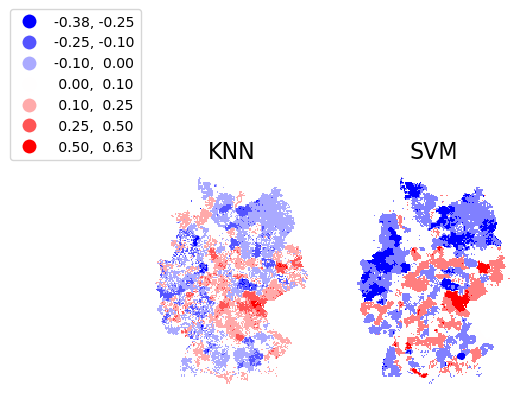

In [186]:
methods_to_plot = ['LR', 'LR_Ridge', 'LR_Lasso', 'LR_Elastic', 'GAM', 'RF', 'AdaB', 'XGBoost']
for i in range(len(methods_to_plot)):
    methods_to_plot[i] = 'diff_' + methods_to_plot[i]
all_maps_plot(output_path, methods_to_plot, 4, color_map= 'bwr', file_name= 'Plots/diff_all_methods_maps', bins = [-0.25, 0, 0.25, 0.5], output_var='cvd_mortal')
# all_maps_plot(output_path, methods_to_plot, 4, color_map= 'bwr', file_name= 'Plots/diff_all_methods_maps', bins = [-1, 0, 1, 2.5], output_var='cvd_mortal')
# all_maps_plot(output_path, methods_to_plot, 4, color_map= 'bwr', file_name= 'Plots/diff_all_methods_maps', bins = [-1, 0, 1, 2.5, 3.5], output_var='cvd_mortal')

### Make performance correlation plots

In [187]:
# plt.figure()
# sns.set(style="ticks", color_codes=True)
# sns.pairplot(preds, corner=True, kind="reg", plot_kws={'line_kws':{'color':'red'}})
# plt.savefig(output_path + 'Plots/Performance_correlation')

In [188]:
# correlation_matrix = preds.corr(method='spearman')
# upper_corr_matrix = np.tril(correlation_matrix)
# plt.figure()
# sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Reds', mask = upper_corr_matrix )
# plt.savefig(output_path + 'Plots/Performance_correlation_Heatmap')

In [189]:
def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

<Figure size 640x480 with 0 Axes>

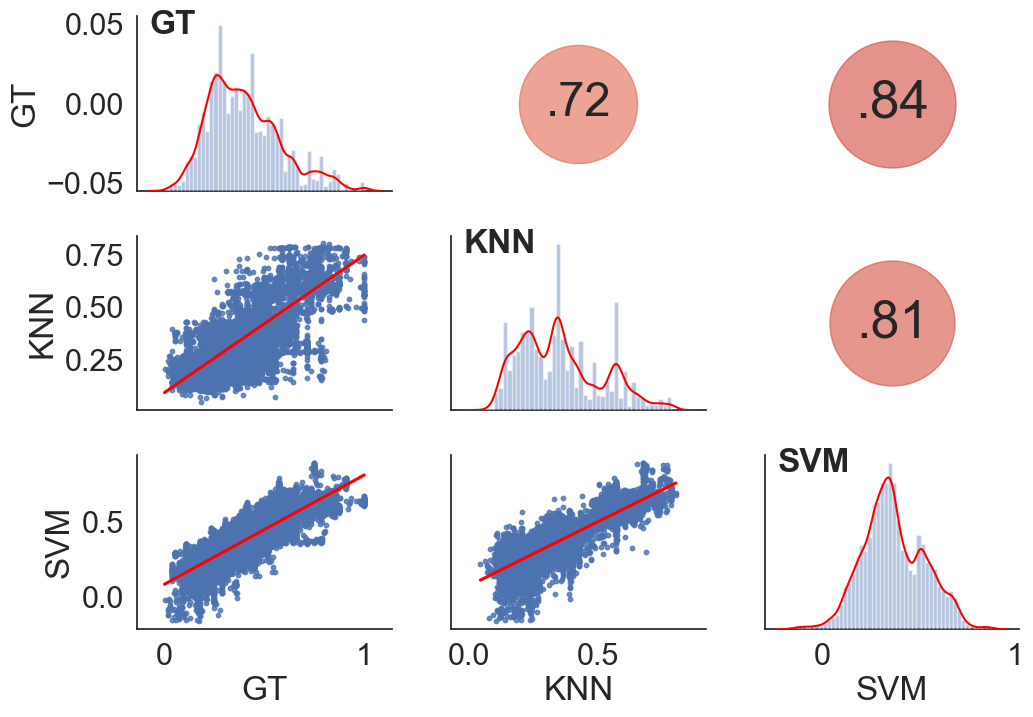

In [190]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
plt.figure()
sns.set(style='white', font_scale=2)
g = sns.PairGrid(preds, aspect=1.4, diag_sharey=False)
#g.map_lower(sns.regplot, lowess=True, ci=True, line_kws={'color': 'red'})
g.map_lower(sns.regplot, scatter_kws={'s':10}, line_kws={'color': 'red'})
g.map_diag(sns.distplot, kde_kws={'color': 'red'})
g.map_diag(annotate_colname)
g.map_upper(corrdot)

plt.savefig(output_path + 'Plots/scatter_corr')